# prep data

In [132]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import pyreadstat
import numpy as np
from prince import MCA
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip install pyreadstat

In [63]:
import pyreadstat
wave1_file = 'D:\RRR\Project Athena\Datathon2021\data\W1 Merged Data\Wave.1_Data\Merge\Wave1_20170906.sav'
wave2_file = 'D:\RRR\Project Athena\Datathon2021\data\W2 Merged Data/2w-3rd_release_all\merge\Wave2_20170724.sav'

df1, meta1 = pyreadstat.read_sav(wave1_file)
df1, meta2 = pyreadstat.read_sav(wave2_file)
meta_dict1 = meta1.column_names_to_labels
meta_dict2 = meta2.column_names_to_labels

df1.head(), df2.head()

(   country  idnumber  level3  yrsurvey  se002  se003  se003a  se004  se004a  \
 0      4.0       1.0     1.0    2002.0    1.0    5.0    38.0    NaN     1.0   
 1      4.0       2.0     1.0    2002.0    2.0   10.0    60.0    NaN     1.0   
 2      4.0       3.0     1.0    2002.0    2.0   10.0    69.0    NaN     1.0   
 3      4.0       4.0     1.0    2002.0    2.0    5.0    39.0    NaN     1.0   
 4      4.0       5.0     1.0    2002.0    1.0    7.0    48.0    NaN     1.0   
 
    se005  ...  ir010e  w_jp  w_hk  w_kr      w_cn  w_mo  w_ph  w_tw  w_th  \
 0    5.0  ...     NaN   NaN   NaN   NaN  0.621390   NaN   NaN   NaN   NaN   
 1    4.0  ...     NaN   NaN   NaN   NaN  0.446785   NaN   NaN   NaN   NaN   
 2    1.0  ...     NaN   NaN   NaN   NaN  0.583658   NaN   NaN   NaN   NaN   
 3    8.0  ...     NaN   NaN   NaN   NaN  0.490000   NaN   NaN   NaN   NaN   
 4    4.0  ...     NaN   NaN   NaN   NaN  0.396647   NaN   NaN   NaN   NaN   
 
    w_all  
 0   0.62  
 1   0.45  
 2   0.58  


## lookup func

In [59]:
# find str in dict, return all keys matching str
def find_str_in_dict(str, dict):
    key_seq = []
    for key, value in dict.items():
        # print(type(value))
        if value is not None:
            if str in value:
                key_seq = np.append(key_seq, key)
    
    print(key_seq)
    for key in key_seq:
        print(dict[key])
    
    return None
    
str_lookup = 'income'
find_str_in_dict(str_lookup, meta_dict1)
find_str_in_dict(str_lookup, meta_dict2)

annual income: national quintiles
['se009']
annual income: national quintiles
['se009']


In [24]:
# find string in df columns
df2.columns[df2.columns.str.contains('q111')]

Index(['q111'], dtype='object')

## drop nan-rich countries

In [150]:
#Drop columns that have no disambiguation or are not crucial for analysis

df1_trunc = df1.drop(['w_all', 'ir9_2', 'idnumber'], axis=1, inplace=False, errors='ignore')
df1_trunc_no_silen_countries = df1_trunc[(df1_trunc['country']!=5) & (df1_trunc['country']!=12)]
# df1_trunc[df1_trunc['q6'].isna()]['country'].hist()

# find and drop countries that caused all missing values in a column
count = 0
silen_countries = {}
cols_to_drop = []
for c in df1_trunc_no_silen_countries.columns:
    if df1_trunc_no_silen_countries[c].isnull().values.any():
        # print(c)
        unique_countries = list(df1_trunc_no_silen_countries[df1_trunc_no_silen_countries[c].isna()]['country'].unique())
        cols_to_drop += [c]
        if len(unique_countries) == 1:
            if unique_countries[0] not in silen_countries.keys():
                silen_countries[unique_countries[0]] = 1
            else:
                silen_countries[unique_countries[0]] += 1
        # print('\n')
    if not df1_trunc_no_silen_countries[c].isnull().values.any():
        count += 1
print(silen_countries) 
print(count)
df1_trunc_no_nan = df1_trunc_no_silen_countries.drop(cols_to_drop, axis=1, inplace=False)
# df1_trunc = df1_trunc.fillna(-1)

{8.0: 1, 4.0: 2}
4


In [151]:
#Drop columns that have no disambiguation or are not crucial for analysis

df2_trunc = df2.drop(['w_all', 'ir9_2', 'idnumber'], axis=1, inplace=False)
df2_trunc_no_mongol_no_camb = df2_trunc[(df2_trunc['country']!=5) & (df2_trunc['country']!=12)]
# df2_trunc[df2_trunc['q6'].isna()]['country'].hist()

# find and drop countries that caused all missing values in a column
count = 0
silen_countries = {}
cols_to_drop = []
for c in df2_trunc_no_mongol_no_camb.columns:
    if df2_trunc_no_mongol_no_camb[c].isnull().values.any():
        # print(c)
        unique_countries = list(df2_trunc_no_mongol_no_camb[df2_trunc_no_mongol_no_camb[c].isna()]['country'].unique())
        cols_to_drop += [c]
        if len(unique_countries) == 1:
            if unique_countries[0] not in silen_countries.keys():
                silen_countries[unique_countries[0]] = 1
            else:
                silen_countries[unique_countries[0]] += 1
        # print('\n')
    if not df2_trunc_no_mongol_no_camb[c].isnull().values.any():
        count += 1
print(silen_countries) 
print(count)
df2_trunc_no_nan = df2_trunc_no_mongol_no_camb.drop(cols_to_drop, axis=1, inplace=False)
# df2_trunc = df2_trunc.fillna(-1)

{4.0: 15, 2.0: 20, 3.0: 10, 10.0: 1, 8.0: 2}
87


# Multiple correspondence analysis (MCA)
https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1

## example code

In [65]:
tips = sns.load_dataset('tips')
tips.drop(['total_bill', 'tip'], axis =1, inplace = True)

In [110]:
tips

sex smoker   day    time  size
0    Female     No   Sun  Dinner     2
1      Male     No   Sun  Dinner     3
2      Male     No   Sun  Dinner     3
3      Male     No   Sun  Dinner     2
4    Female     No   Sun  Dinner     4
..      ...    ...   ...     ...   ...
239    Male     No   Sat  Dinner     3
240  Female    Yes   Sat  Dinner     2
241    Male    Yes   Sat  Dinner     2
242    Male     No   Sat  Dinner     2
243  Female     No  Thur  Dinner     2

[244 rows x 5 columns]

In [113]:
tips2 = tips[['size']].copy()
tips2['size2'] = tips2['size']**2
tips2

size  size2
0       2      4
1       3      9
2       3      9
3       2      4
4       4     16
..    ...    ...
239     3      9
240     2      4
241     2      4
242     2      4
243     2      4

[244 rows x 2 columns]

In [121]:
# cast float column to str in df
tips2['size'] = tips2['size'].astype(str)
tips2['size2'] = tips2['size2'].astype(str)
type(tips2['size2'][0])

str

In [67]:
# !pip install prince --user

  Using cached prince-0.7.1-py3-none-any.whl (21 kB)
  Using cached pandas-1.3.4-cp37-cp37m-win_amd64.whl (10.0 MB)


ERROR: otter-grader 2.2.6 requires google-auth-oauthlib, which is not installed.
ERROR: otter-grader 2.2.6 requires gspread, which is not installed.


In [68]:
from prince import MCA
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(tips)
tips_mca = mca.transform(tips)
tips_mca.head()

0         1
0 -0.179709 -0.372317
1 -0.363840 -0.487036
2 -0.363840 -0.487036
3 -0.415941 -0.550888
4 -0.147590 -0.305220

In [122]:
from prince import MCA
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(tips2)
tips_mca = mca.transform(tips2)
tips_mca.head()

0         1
0 -0.129099 -0.576453
1 -0.129099  0.151963
2 -0.129099  0.151963
3 -0.129099 -0.576453
4 -0.129099  1.746597

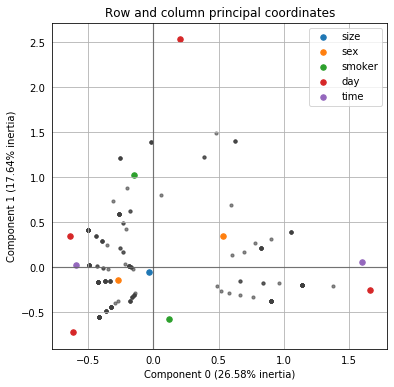

In [69]:
mca.plot_coordinates(X = tips)


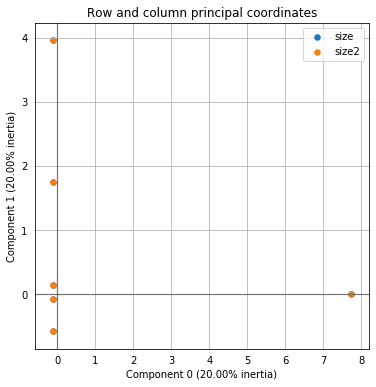

In [123]:
mca.plot_coordinates(X = tips2)


In [124]:
mca.explained_inertia_


[0.20000000000000018, 0.2]

## try wave 2

In [128]:
# income vs legitimacy
col_name = ['se9', 'q123', 'q111']
df_temp = df2[col_name].copy()
print(df_temp.size)
print(df2.se9.unique(), df2.q123.unique(), df2.q111.unique())

# drop nan
df_temp = df_temp.dropna()
print(df_temp.size)

def df_column_datatype_to_str(df, col_name):
    df[col_name] = df[col_name].astype(str)
    return df

df_temp = df_column_datatype_to_str(df_temp, col_name)
print(df_temp.se9.unique(), df_temp.q123.unique(), df_temp.q111.unique())

59394
['5.0' '1.0' '2.0' '3.0' '4.0' '98.0' '99.0' 'nan' '97.0'] ['3.0' '2.0' '4.0' '1.0' '8.0' '5.0' '9.0' '7.0' 'nan'] ['2.0' '1.0' '3.0' '8.0' '4.0' '9.0' '7.0' 'nan']
59394
['5.0' '1.0' '2.0' '3.0' '4.0' '98.0' '99.0' 'nan' '97.0'] ['3.0' '2.0' '4.0' '1.0' '8.0' '5.0' '9.0' '7.0' 'nan'] ['2.0' '1.0' '3.0' '8.0' '4.0' '9.0' '7.0' 'nan']


In [99]:
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(df_temp)
t_mca = mca.transform(df_temp)
t_mca.sample(5)

0         1
19259 -0.579332  0.705867
14032 -0.963988  0.087037
16116 -0.963988  0.087037
2728  -0.336627 -0.123570
11623 -0.074507 -0.182797

ZeroDivisionError: float division by zero

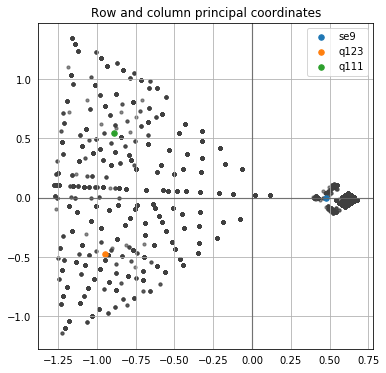

In [100]:
mca.plot_coordinates(X = df_temp)

In [109]:
# find column in df without nan
print(len(df2.columns[df2.isna().any()]), len(df2.columns))

# difference between 2 arrays
np.setdiff1d(df2.columns, df2.columns[df2.isna().any()])

236 252


array(['country', 'idnumber', 'q1', 'q10', 'q119', 'q12', 'q13', 'q15',
       'q2', 'q25', 'q3', 'q4', 'q5', 'q8', 'q9', 'w_all'], dtype=object)

## full wave 1

In [152]:
df1_trunc_no_nan_stringy = df1_trunc_no_nan.astype(str)
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(df1_trunc_no_nan_stringy)
df1_trunc_mca = mca.transform(df1_trunc_no_nan_stringy)
df1_trunc_mca.head()

0         1
0 -0.323549 -0.009327
1 -0.323549 -0.009327
2 -0.323549 -0.009327
3 -0.347001  0.071125
4 -0.323549 -0.009327

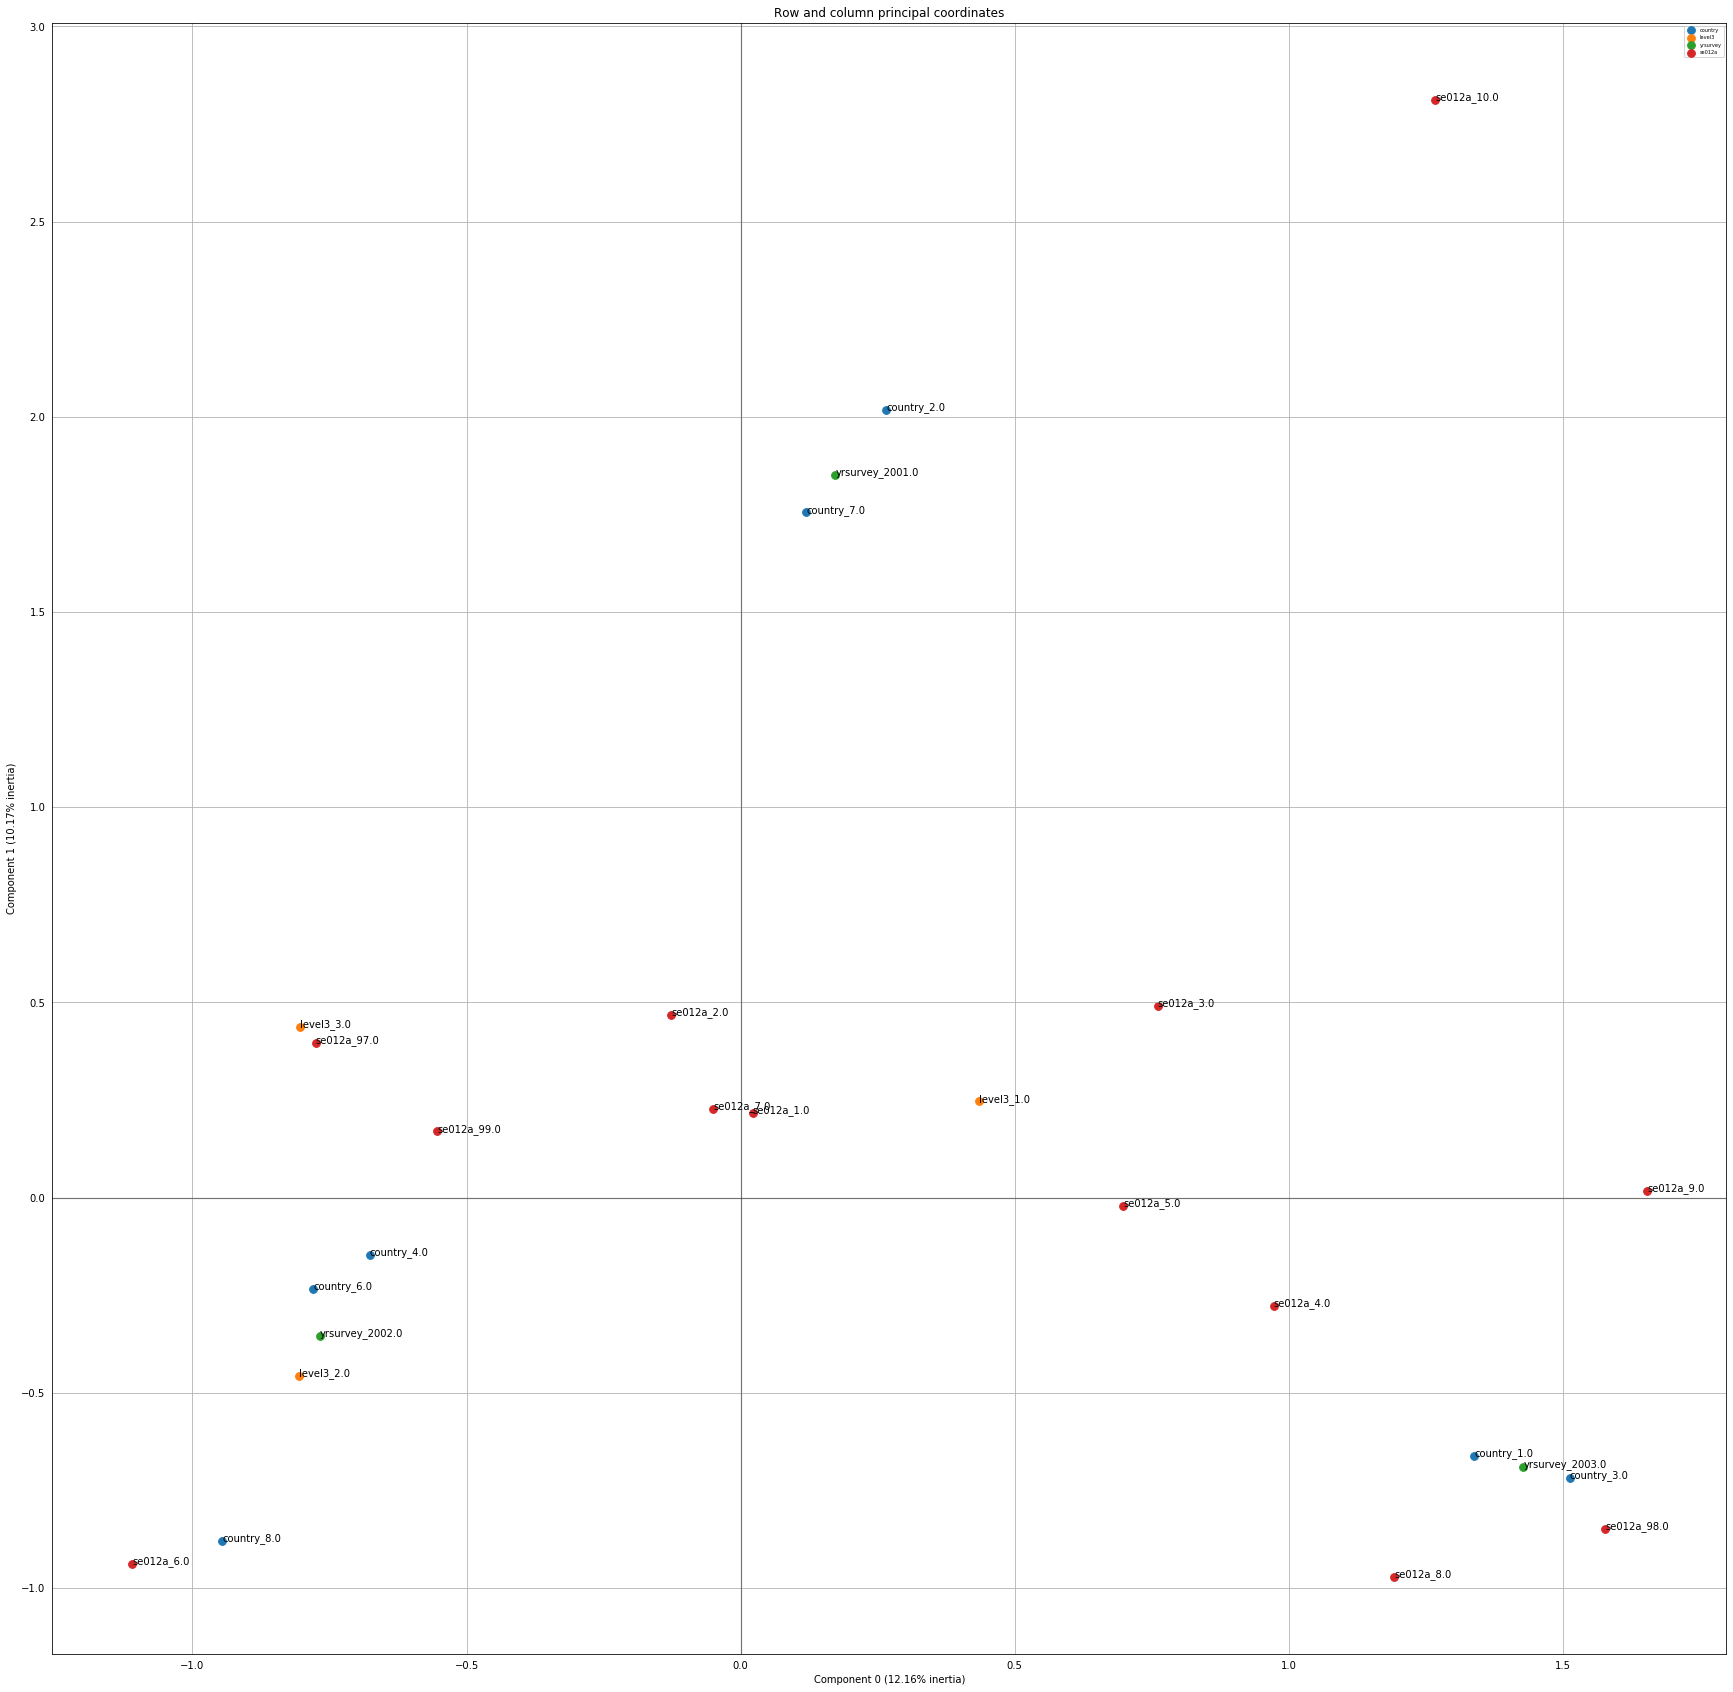

In [153]:
# fig = figure(num=None, figsize=(100, 100), dpi=150, facecolor='w', edgecolor='k')
# plt.rcParams['figure.figsize'] = (100, 100)
# plt.rcParams['figure.dpi'] = 400
ax = mca.plot_coordinates(X=df1_trunc_no_nan_stringy,
    ax=None,
    figsize=(30, 30),
    show_row_points=False,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=60,
    show_column_labels=True)
plt.legend(prop={'size': 5})
plt.savefig("MCA_wave1.pdf", format='pdf', bbox_inches='tight')

## full wave 2

In [155]:
df2_trunc_no_nan_stringy = df2_trunc_no_nan.astype(str)
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(df2_trunc_no_nan_stringy)
df2_trunc_mca = mca.transform(df2_trunc_no_nan_stringy)
df2_trunc_mca.head()

0         1
0 -0.489131  0.388370
1 -0.332164  0.167274
2 -0.379590  0.148985
3 -0.336874 -0.104851
4 -0.497845  0.493330

In [163]:
df2_trunc_no_nan_stringy['q2']


0        1.0
1        4.0
2        4.0
3        3.0
4        4.0
        ... 
19793    4.0
19794    4.0
19795    5.0
19796    4.0
19797    2.0
Name: q2, Length: 17587, dtype: object

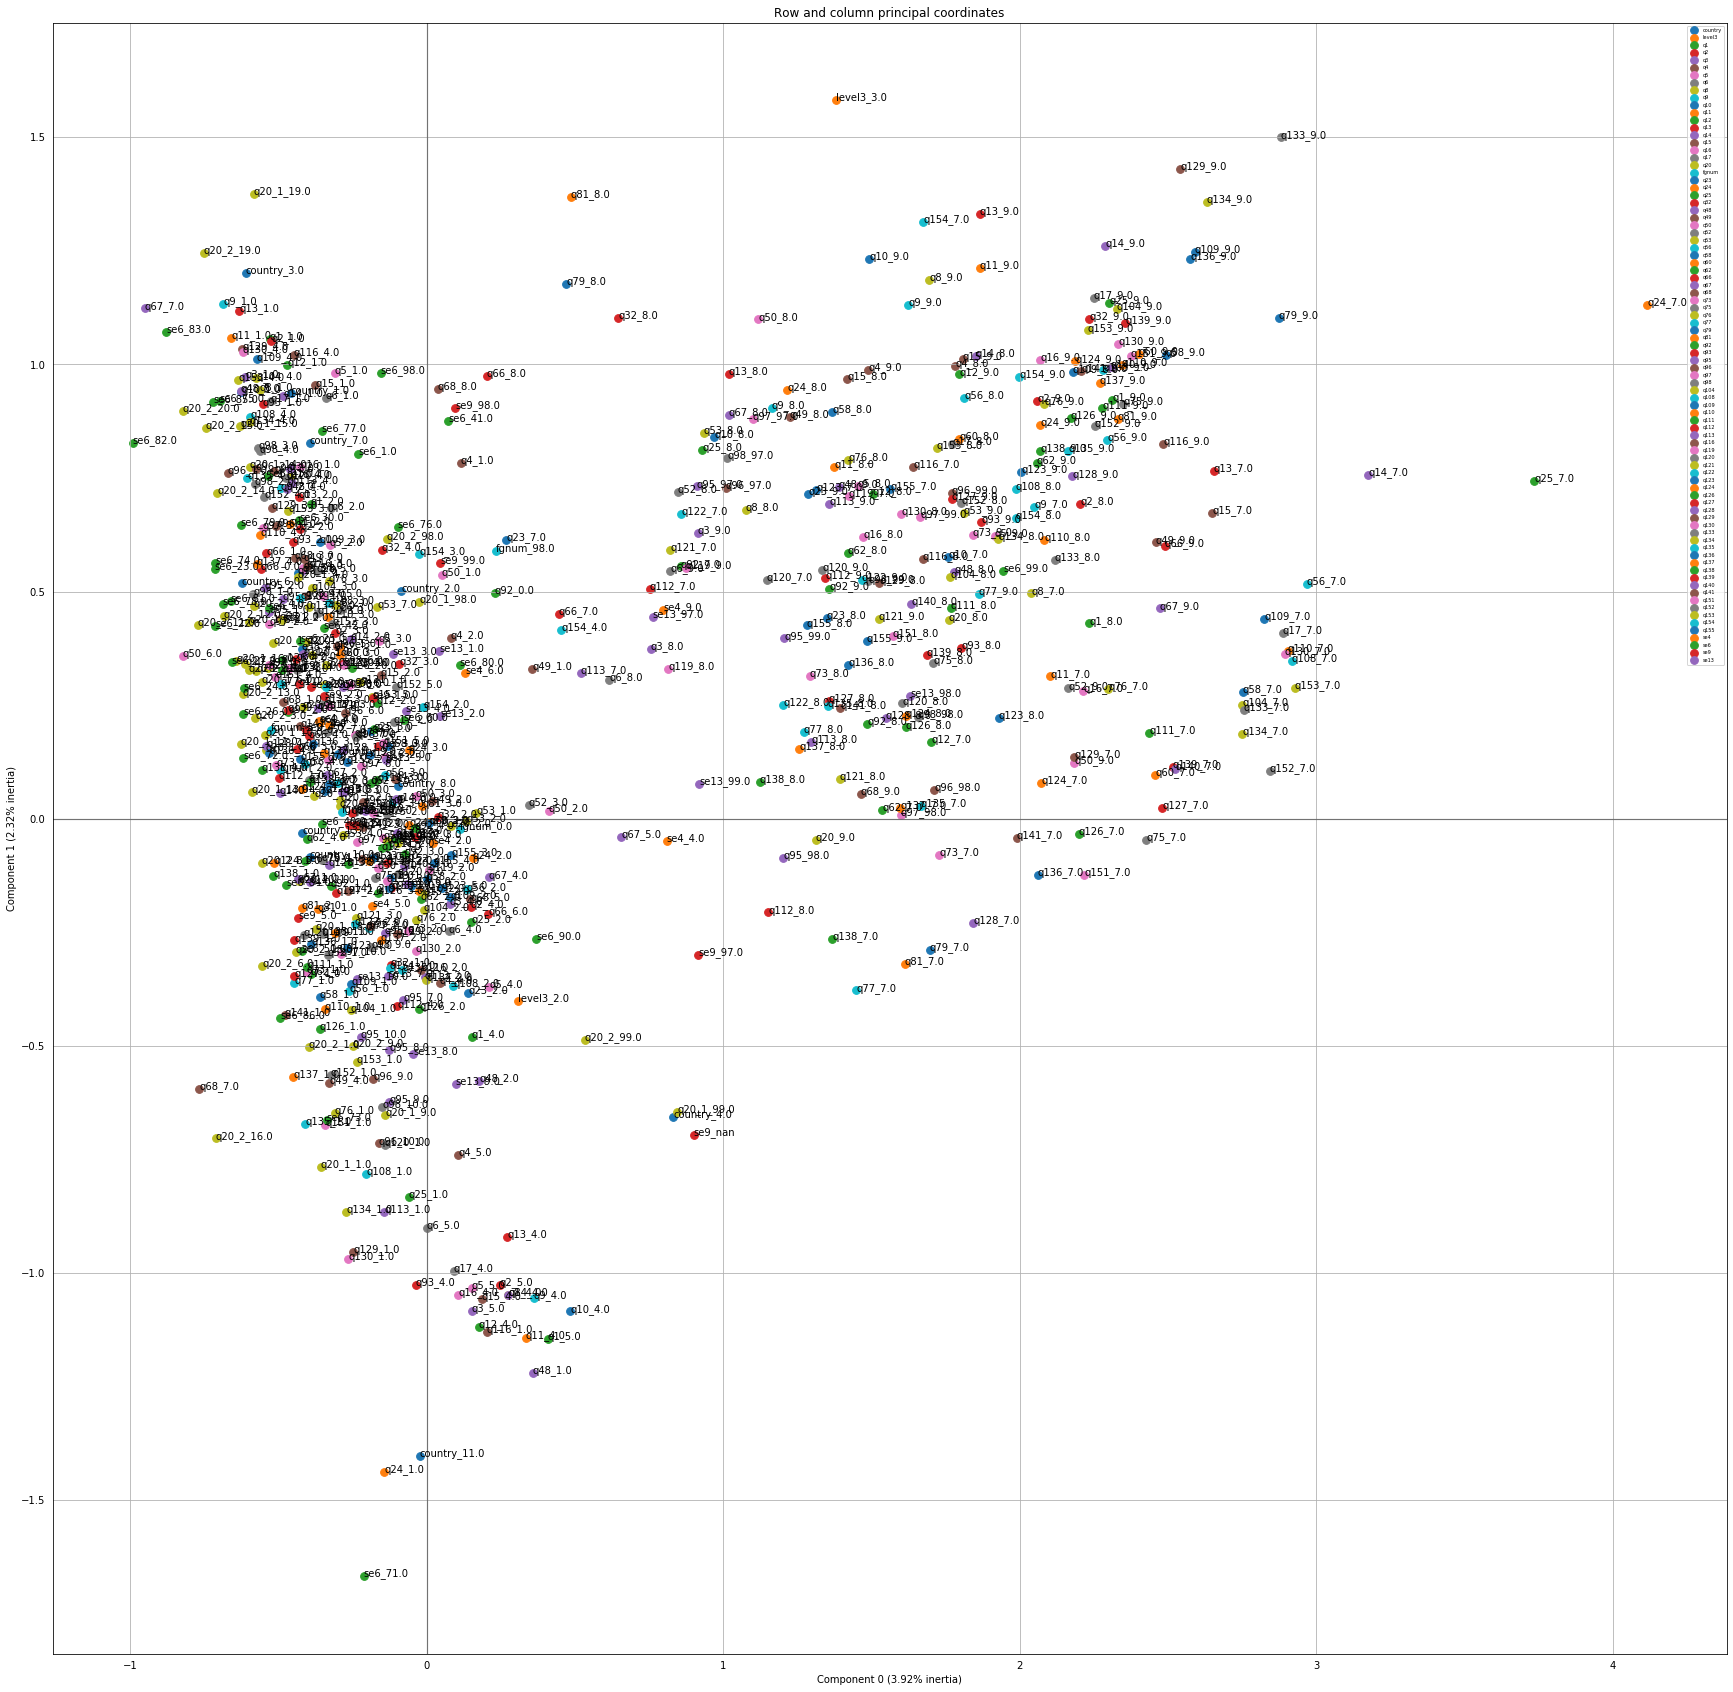

In [156]:
# fig = figure(num=None, figsize=(100, 100), dpi=150, facecolor='w', edgecolor='k')
# plt.rcParams['figure.figsize'] = (100, 100)
# plt.rcParams['figure.dpi'] = 400
ax = mca.plot_coordinates(X=df2_trunc_no_nan_stringy,
    ax=None,
    figsize=(30, 30),
    show_row_points=False,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=60,
    show_column_labels=True)
plt.legend(prop={'size': 5})
# plt.savefig("MCA_wave2.pdf", format='pdf', bbox_inches='tight')


In [161]:
mca.plot_rows_columns()


AttributeError: 'MCA' object has no attribute 'plot_rows_columns'

In [159]:
dir(mca)

['U_',
 'V_',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_is_fitted',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 'benzecri',
 'check_input',
 'col_masses_',
 'column_coordinates',
 'copy',
 'eigenvalues_',
 'engine',
 'explained_inertia_',
 'fit',
 'fit_transform',
 'get_params',
 'n_components',
 'n_iter',
 'plot_coordinates',
 'random_state',
 'row_coordinates',
 'row_masses_',
 's_',
 'set_params',
 'total_inertia_',
 'transform']